# NIRSpec G395H Pipeline Workbook
## ERS WASP 39b
### Reduction_v7

In [1]:
# %matplotlib nbagg

In [2]:
workbook = 'nrs1 Reduction_v7'

In [3]:
import imp
import exotic_jedi as jedi
imp.reload(jedi)

import numpy as np
import matplotlib.pyplot as plt
import glob
from astropy.io import fits
import pickle

In [12]:
plt.rcParams['figure.figsize'] = [10.0, 3.0]           # Dimensions
plt.rcParams['figure.dpi'] = 300                       # Resolution
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['image.aspect'] = 7                      # Aspect ratio
plt.rcParams['lines.linewidth'] = 1

cmap = plt.cm.magma
cmap.set_bad('k',1.)

from matplotlib import cycler
plt.rcParams['image.cmap'] = 'magma'                   # Colormap.
plt.rcParams['image.interpolation'] = None
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['axes.prop_cycle'] = cycler(color=['dodgerblue','lawngreen','tomato','darkorchid','gold','lightgray'])

/tmp/ipykernel_3361054/3188816359.py:8: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("magma").copy()
  cmap.set_bad('k',1.)
/tmp/ipykernel_3361054/3188816359.py:12: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  plt.rcParams['image.interpolation'] = None


## Load in observations

In [5]:
# Load in data
data_files_path = '/data/praxis2/shared_area/JWST/Reductions/reduction_v7/stage_1/' #point to where the data is
rateints_files_nrs1 = glob.glob(data_files_path+'*nrs1_stage_1.fits')
rateints_files_nrs2 = glob.glob(data_files_path+'*nrs2_stage_1.fits')



# Grab relevant ancillary files, etc
ancillary_files = '/data/praxis2/shared_area/JWST/Reductions/times_wvls/'
times = np.loadtxt(ancillary_files + 'jw01366003001_04101_00001-seg001-003_nrs1_times.txt')

In [6]:
# Get the gain from the crds files for error calculation

gain = np.median(fits.open('/home/ym20900/jwst_nirspec_gain_nrs1.fits')[1].data)

In [7]:
midtime_bjd = times[:,5]

# Get the integration time from the time file for error calculation
integration_time = np.median(abs((times[:,4]-times[:,6])*24*60*60))

print(len(midtime_bjd), integration_time)

465 63.158400007523596


Since the observations come down in segments, we want to stitch them back together to run this full dataset.

We'll use Jeff Valenti's unsegment function, which unpacks everything in a nice 3D array for us. We also need to make sure we do this for both the science and data quality flag extensions so we can clean everything up

In [8]:
sorted(rateints_files_nrs1)

['/data/praxis2/shared_area/JWST/Reductions/reduction_v7/stage_1/jw01366003001_04101_00001-seg001_nrs1_stage_1.fits',
 '/data/praxis2/shared_area/JWST/Reductions/reduction_v7/stage_1/jw01366003001_04101_00001-seg002_nrs1_stage_1.fits',
 '/data/praxis2/shared_area/JWST/Reductions/reduction_v7/stage_1/jw01366003001_04101_00001-seg003_nrs1_stage_1.fits']

In [9]:
trimming = 500

wvl_fits = fits.open(ancillary_files + 'jw01366003001_04101_00001-seg001_nrs1_stage_2_wavelengthmap.fits')[0].data
wvl_fits = wvl_fits[:,trimming:]

sci_cube, _ = jedi.unsegment(sorted(rateints_files_nrs1), 1)
sci_cube = sci_cube[:,:,trimming:-5]


dq_cube, size = jedi.unsegment(sorted(rateints_files_nrs1), 3)
dq_cube = dq_cube[:,:,trimming:-5]

print(dq_cube.shape)

(465, 32, 1543)


In [10]:
jedi.dq_flag_metrics(sci_cube, dq_cube, plot_bit=None)

===== DQ flags info =====
Found 20927 pixels with DQ bit=0 name=DO_NOT_USE.
Found 1291 pixels with DQ bit=1 name=SATURATED.
Found 96172 pixels with DQ bit=2 name=JUMP_DET.
Found 0 pixels with DQ bit=3 name=DROPOUT.
Found 0 pixels with DQ bit=4 name=OUTLIER.
Found 0 pixels with DQ bit=5 name=PERSISTENCE.
Found 0 pixels with DQ bit=6 name=AD_FLOOR.
Found 0 pixels with DQ bit=7 name=RESERVED.
Found 0 pixels with DQ bit=8 name=UNRELIABLE_ERROR.
Found 0 pixels with DQ bit=9 name=NON_SCIENCE.
Found 39525 pixels with DQ bit=10 name=DEAD.
Found 0 pixels with DQ bit=11 name=HOT.
Found 0 pixels with DQ bit=12 name=WARM.
Found 8835 pixels with DQ bit=13 name=LOW_QE.
Found 0 pixels with DQ bit=14 name=RC.
Found 0 pixels with DQ bit=15 name=TELEGRAPH.
Found 0 pixels with DQ bit=16 name=NONLINEAR.
Found 0 pixels with DQ bit=17 name=BAD_REF_PIXEL.
Found 0 pixels with DQ bit=18 name=NO_FLAT_FIELD.
Found 8835 pixels with DQ bit=19 name=NO_GAIN_VALUE.
Found 0 pixels with DQ bit=20 name=NO_LIN_CORR.
Foun

okay so that's the file structure and our dq flag breakdown

quick look

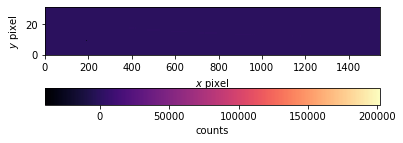

/tmp/ipykernel_3361054/2435248013.py:11: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(initial_look), vmin=-1, vmax=2.5)
/tmp/ipykernel_3361054/2435248013.py:11: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(initial_look), vmin=-1, vmax=2.5)


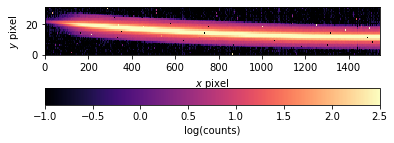

In [11]:
initial_look = (sci_cube[271])

plt.figure()
plt.imshow((initial_look))#, vmin=0, vmax=4.5)
plt.xlabel("$x$ pixel")
plt.ylabel("$y$ pixel")
plt.colorbar(label="counts", orientation='horizontal')
plt.show()

plt.figure()
plt.imshow(np.log10(initial_look), vmin=-1, vmax=2.5)
#plt.title('{}'.format(workbook))
plt.xlabel("$x$ pixel")
plt.ylabel("$y$ pixel")
plt.colorbar(label="log(counts)", orientation='horizontal')
plt.show()

yeay! a nirspec!

## Data Quality Flags

Using the jwst pipeline data quality flags, we'll first replace any flagged pixels with the median of its neighbours - so pixels in the same row within a window region

We can specify which flags we want to replace using the bits_to_mask arguement, where each number corresponds to the bit for an individual flag

Some key examples are
- 0 DO_NOT_USE, bad pixels (dq flag = 1)
- 1 SATURATED, pixel saturated during exposure (dq flag = 2)
- 10 DEAD, dead pixel (dq flag = 1024)
- 11 HOT, hot pixel

Sometimes the flags seem a little overzealous on the hot pixel one, so maybe check this a couple times before committing!

There's more detail on each of the flags in Table 3 here: https://jwst-pipeline.readthedocs.io/_/downloads/en/latest/pdf/

(this step takes a while, once it's started running go have a snack!)

In [12]:
rawest_data = jedi.dq_flat_replace(sci_cube, dq_cube, bits_to_mask=[0,1,10,11,13,19], window_size=4)

100%|████████████████████████████████| 146110/146110 [00:07<00:00, 18725.25it/s]


Replaced  56626  pixels


## Outliers Through Space and Time

(would be a cool movie!)

Now we want to check for any significant outliers throughout the dataset, either pixels that are constantly Not Good (space), or pixels that are not good during a particular integration (time).

We'll replace the outliers with the median of values near them in which ever axis they are outliers

In [13]:
raw_data = jedi.outliers_through_time(rawest_data, window_size=10, n_sig=20, plot=False)

# WINDOW SIZE IS IMPORTANT


No more outliers found
In total 353 outliers were found


100%|█████████████████████████████████████████| 465/465 [02:17<00:00,  3.37it/s]


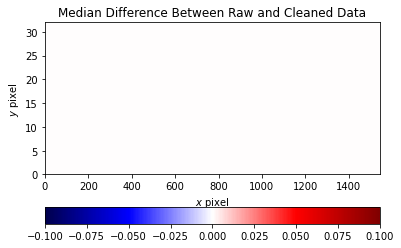

In [14]:
cleaned_data, counter = jedi.outliers_through_space(raw_data, replace_window=4, search_window=21, poly_order=0, n_sig=6, plot=True)

/tmp/ipykernel_1799195/3584592247.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(initial_look))#, vmin=-1, vmax=2.5)
/tmp/ipykernel_1799195/3584592247.py:2: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(initial_look))#, vmin=-1, vmax=2.5)


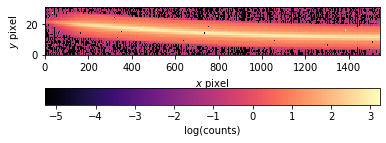

/tmp/ipykernel_1799195/3584592247.py:10: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(rawest_data[113]))#, vmin=-1, vmax=2.5)
/tmp/ipykernel_1799195/3584592247.py:10: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(rawest_data[113]))#, vmin=-1, vmax=2.5)


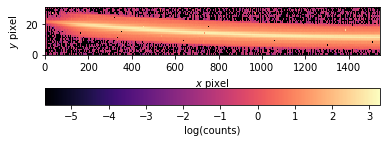

/tmp/ipykernel_1799195/3584592247.py:18: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(raw_data[113]))#, vmin=-1, vmax=2.5)
/tmp/ipykernel_1799195/3584592247.py:18: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(raw_data[113]))#, vmin=-1, vmax=2.5)


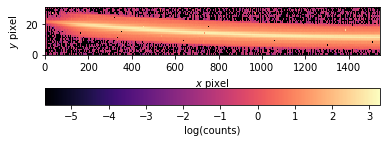

/tmp/ipykernel_1799195/3584592247.py:26: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(cleaned_data[113]))#, vmin=-1, vmax=2.5)
/tmp/ipykernel_1799195/3584592247.py:26: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(cleaned_data[113]))#, vmin=-1, vmax=2.5)


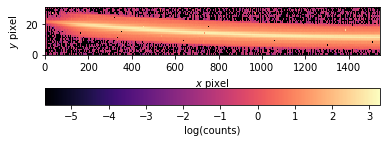

In [15]:
plt.figure()
plt.imshow(np.log10(initial_look))#, vmin=-1, vmax=2.5)
#plt.title('{}'.format(workbook))
plt.xlabel("$x$ pixel")
plt.ylabel("$y$ pixel")
plt.colorbar(label="log(counts)", orientation='horizontal')
plt.show()

plt.figure()
plt.imshow(np.log10(rawest_data[113]))#, vmin=-1, vmax=2.5)
#plt.title('{}'.format(workbook))
plt.xlabel("$x$ pixel")
plt.ylabel("$y$ pixel")
plt.colorbar(label="log(counts)", orientation='horizontal')
plt.show()

plt.figure()
plt.imshow(np.log10(raw_data[113]))#, vmin=-1, vmax=2.5)
#plt.title('{}'.format(workbook))
plt.xlabel("$x$ pixel")
plt.ylabel("$y$ pixel")
plt.colorbar(label="log(counts)", orientation='horizontal')
plt.show()

plt.figure()
plt.imshow(np.log10(cleaned_data[113]))#, vmin=-1, vmax=2.5)
#plt.title('{}'.format(workbook))
plt.xlabel("$x$ pixel")
plt.ylabel("$y$ pixel")
plt.colorbar(label="log(counts)", orientation='horizontal')
plt.show()



## Find the aperture

Here we want to fit a gaussian to each column of the test image to get the center and width, and then fit a polynomial to each of those across the x axis



/tmp/ipykernel_1799195/619788192.py:46: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(test_image))#,vmin=0,vmax=4.5)
/tmp/ipykernel_1799195/619788192.py:46: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(test_image))#,vmin=0,vmax=4.5)


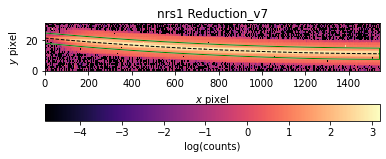

In [16]:
test_image = cleaned_data[100].copy() #/ flat # do our flat field correction on our test image


# Might need to vary these initially to get the thing going

ap_start = 0 # x pixel where we want to start hunting for the trace
ap_end = 1543 # x pixel where the trace ends (or just the edge of the detector probs for g395h)
init_guess = 0.7 # how wide do we think the trace is

# Will want to test different values of these to make sure getting the best lcs

polynomial_order = [4, 4] # what order polynomials to use when fitting the trace position and its width
median_filter_window = 5 # MUST BE ODD NUMBER window size applied to the median filter that smooths the trace widths
aperture_width = 5 # number of fwhms to extend the aperture to

extrapolate_method = 'flatten' # 'flatten', 'continue' or None
continue_value = [0,0]

trace_falls_off = True # set this to True if the trace falls off the top/bottom of the detector
                       # this will enable the aperture to default to the top and bottom edge of the detector
                       # rather than returning an error message


trace_position, trace_width, upper_ap, lower_ap, up_trim, low_trim = jedi.get_aperture(test_image, init_guess, \
                                                                            ap_start, ap_end, \
                                                                            poly_orders=polynomial_order, \
                                                                            width=aperture_width, \
                                                                            medflt=median_filter_window, \
                                                                            extrapolate_method=extrapolate_method,\
                                                                            continue_value=continue_value, \
                                                                            set_to_edge=trace_falls_off)

plt.figure()

if extrapolate_method=='continue':
    ap_start = ap_start-continue_value[0]
    ap_end = ap_end+continue_value[1]

plt.plot(np.arange(ap_start,ap_end),trace_position,color='k',ls='--')
plt.xlabel("$x$ pixel")
plt.ylabel("$y$ pixel")

plt.fill_between(np.arange(0,np.shape(test_image)[1]), upper_ap, lower_ap, facecolor = 'None',edgecolor='w')
plt.fill_between(np.arange(ap_start,ap_end), up_trim, low_trim, facecolor="None", edgecolor='g')

plt.imshow(np.log10(test_image))#,vmin=0,vmax=4.5)
plt.colorbar(label="log(counts)", orientation='horizontal')
plt.title('{}'.format(workbook))

plt.show()

## 1/f noise

We're gonna want to do a column by column median, masking the spectral trace area. 

Let's define a buffer region above and below the aperture to make sure we're definitely not including any of that spectrum

/home/ym20900/ers/w39_g395/r7/exotic_jedi.py:563: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(im),vmin=vmin,vmax=vmax)
/home/ym20900/ers/w39_g395/r7/exotic_jedi.py:563: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(im),vmin=vmin,vmax=vmax)


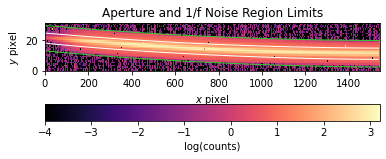

/home/ym20900/ers/w39_g395/r7/exotic_jedi.py:583: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(np.ma.masked_array(im,mask=mask)), vmin=vmin,vmax=vmax)
/home/ym20900/ers/w39_g395/r7/exotic_jedi.py:583: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(np.ma.masked_array(im,mask=mask)), vmin=vmin,vmax=vmax)


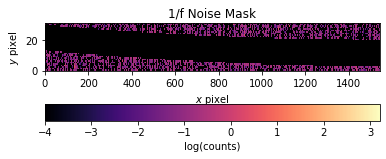

In [17]:
fnoise_mask, _, _ = jedi.f_noise_zone(test_image, upper_ap, lower_ap, ap_buffers=[5,5], plot=True, set_to_edge=True, vmin=-4, vmax=3.2)

Now let's actually remove the 1/f noise from the test image to make sure the region wasn't accidentally clipping anything

/home/ym20900/ers/w39_g395/r7/exotic_jedi.py:615: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(im),vmin=vmin,vmax=vmax)
/home/ym20900/ers/w39_g395/r7/exotic_jedi.py:615: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(im),vmin=vmin,vmax=vmax)


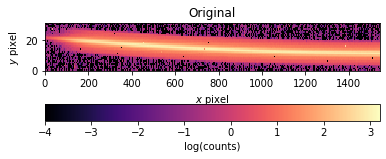

/home/ym20900/ers/w39_g395/r7/exotic_jedi.py:623: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(clean_im),vmin=vmin,vmax=vmax)
/home/ym20900/ers/w39_g395/r7/exotic_jedi.py:623: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(clean_im),vmin=vmin,vmax=vmax)


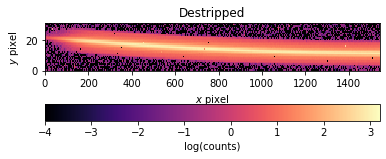

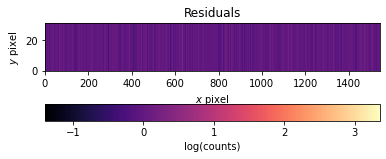

In [18]:
clean_test_im = jedi.remove_fnoise(test_image, fnoise_mask, plot=True, vmin=-4, vmax=3.2)

## Extract!

We want to do an intrapixel extraction so we don't erase all the hard work making a curvy trace

Here we'll quickly compare the intrapixel extraction with a more standard hard edge box so we can see how it impact the **shape** of the spectrum, not just the total flux!

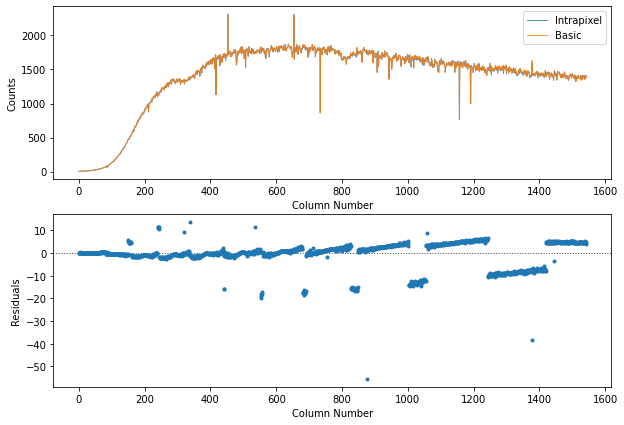

In [19]:
test_spectrum = jedi.intrapixel_extraction(test_image, upper_ap, lower_ap)

test_spectrum_basic = jedi.basic_extraction(test_image, upper_ap, lower_ap)

figure, ax = plt.subplots(2,1, figsize=(10,7))
ax[0].plot(test_spectrum, alpha=0.8, label="Intrapixel")
ax[0].plot(test_spectrum_basic, alpha=0.8, label="Basic")
ax[0].set_xlabel("Column Number")
ax[0].set_ylabel("Counts")
ax[0].legend()

ax[1].plot(test_spectrum-test_spectrum_basic, marker='.', ls='None')
ax[1].axhline(0,ls=':', color='k', alpha=0.7, zorder=0)
ax[1].set_xlabel("Column Number")
ax[1].set_ylabel("Residuals")

plt.show()

The extraction method is important!! The difference isn't just that one gives overall higher flux, they produce spectra with different shapes

## Get! Those! Spectra!

With everything we've set up, it's time to get the spectra and correlate them for x and y pixel shifts

Playing around with the trimming and the high res factors here might be important. In the tuples, each number refers to either the x or y shifts, 

i.e., trim_spec=[value_for_x,value_for_y]

Running intrapixel extraction on 465 spectra
No flat fielding is being performed at this time
1/f noise is being removed


100%|█████████████████████████████████████████| 465/465 [00:28<00:00, 16.60it/s]


Now calculating shifts


100%|█████████████████████████████████████████| 465/465 [00:18<00:00, 25.33it/s]


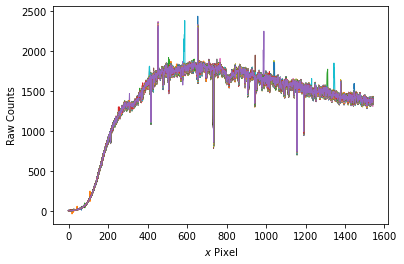

In [20]:
all_spectra, all_y_collapse, x_shifts, y_shifts = jedi.get_stellar_spectra(cleaned_data, upper_ap, lower_ap, \
                                                                      flat=None, f_mask=fnoise_mask, \
                                                                      extract_method="intrapixel",  \
                                                                      shift=True, interpolate_mode="cubic", \
                                                                      trim_spec=[3,1], high_res_factor=[0.01,0.01], \
                                                                      trim_fit=[10,10], \
                                                                      plot=True, set_to_edge = True)

Let's do the same again on the original, uncorrected spectra, without the 1/f noise correction so we can see what difference our cleaning processes have made

In [21]:
unclean_spectra, _, _, _ = jedi.get_stellar_spectra(np.nan_to_num(sci_cube), upper_ap, lower_ap, \
                                                                      flat=None, f_mask=None, \
                                                                      extract_method="intrapixel",  \
                                                                      shift=True, interpolate_mode="cubic", \
                                                                      trim_spec=[3,1], high_res_factor=[0.01,0.01], \
                                                                      trim_fit=[10,10], \
                                                                      plot=False, set_to_edge = False)

Running intrapixel extraction on 465 spectra
No flat fielding is being performed at this time
No 1/f noise correction is being performed


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 50.59it/s]


Now calculating shifts


100%|█████████████████████████████████████████| 465/465 [00:18<00:00, 25.27it/s]


## Wavelength Solution

Using the fits file provided in Stage 1 we need to extract out a wavelength solution. The wavelength solution is a 2D array, and we need to pick a value for each pixel - we can use the trace positions for this

[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan 2.70188874 2.70183029 2.70177183 2.70171335 2.70165487
 2.70159637 2.70153786 2.70147934 2.7014208  2.70136226 2.7013037
 2.70124514 2.70118656 2.70112796 2.70106936 2.70101075 2.70095212
        nan        nan]


NameError: name 'ap_start' is not defined

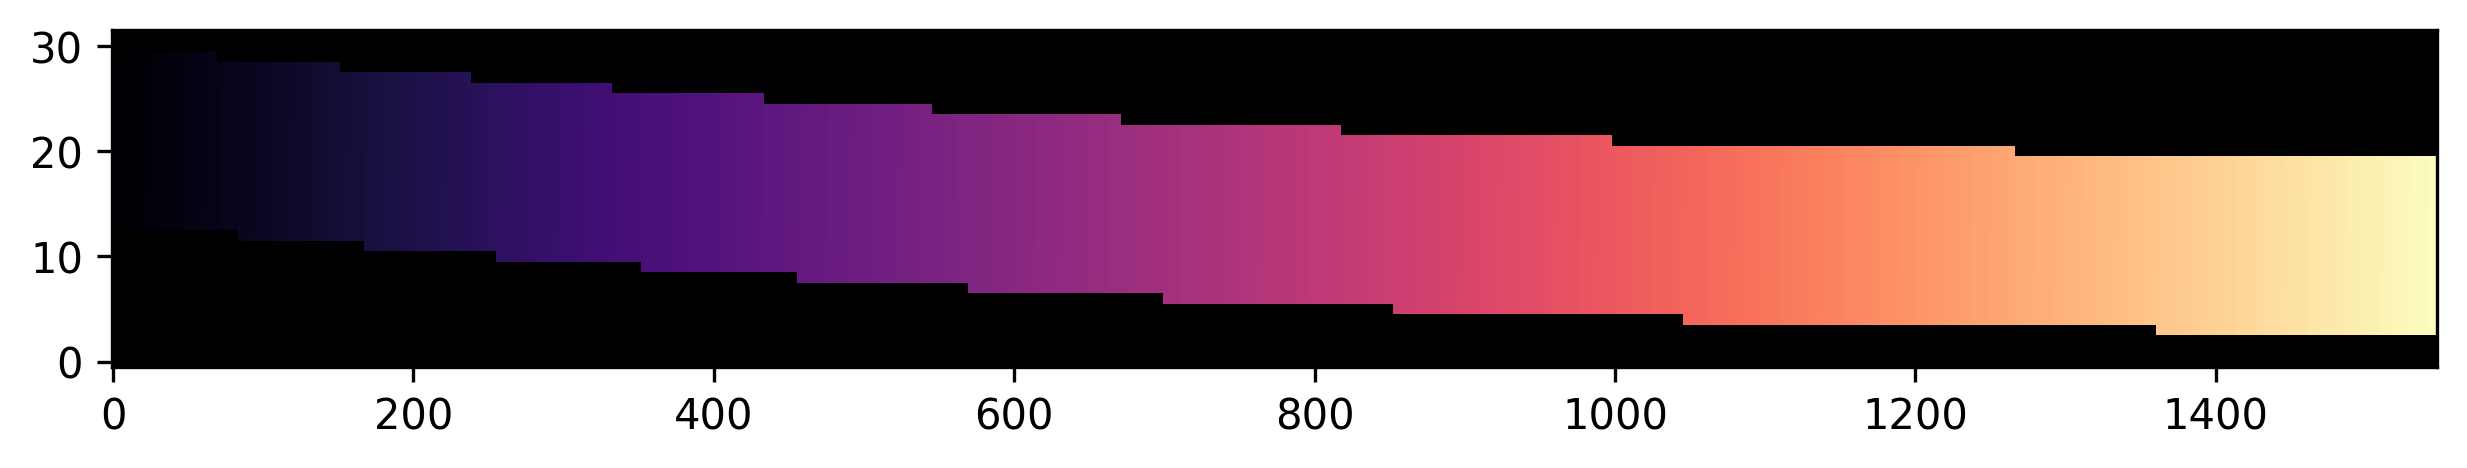

In [16]:
print(wvl_fits[:, 40])

plt.figure()
plt.imshow(wvl_fits)
plt.plot(np.arange(ap_start,ap_end),trace_position,color='w',ls='--')
plt.show()


wvls = []
for count, pixel_column in enumerate(np.arange(ap_start,ap_end)):
    pixel_row = int(trace_position[count])
    wvls.append(wvl_fits[pixel_row, pixel_column])
    
print(len(wvls))



## Diagnostic Plots and Visualisations

We can plot the stellar spectra up like a chromatic plot

In [23]:
# Make some fake array for plotting, can be useful for locating troublesome pixels

fake_time = np.arange(np.shape(all_spectra)[0])

fake_wvls = np.arange(np.shape(all_spectra)[1])

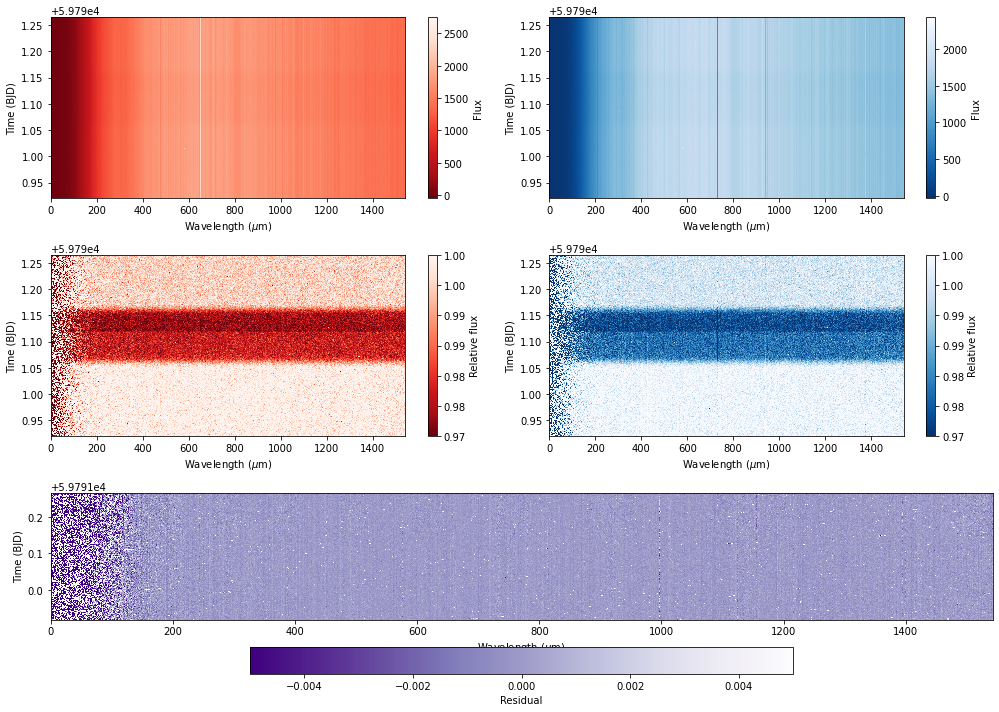

In [24]:
jedi.compare_2d_spectra(all_spectra[:], unclean_spectra[:], fake_wvls[:], midtime_bjd, \
                   time_units="BJD", residual_limits=[-0.005,0.005], spectra_limits=[0.975,1.005])

Check the x and y shifts

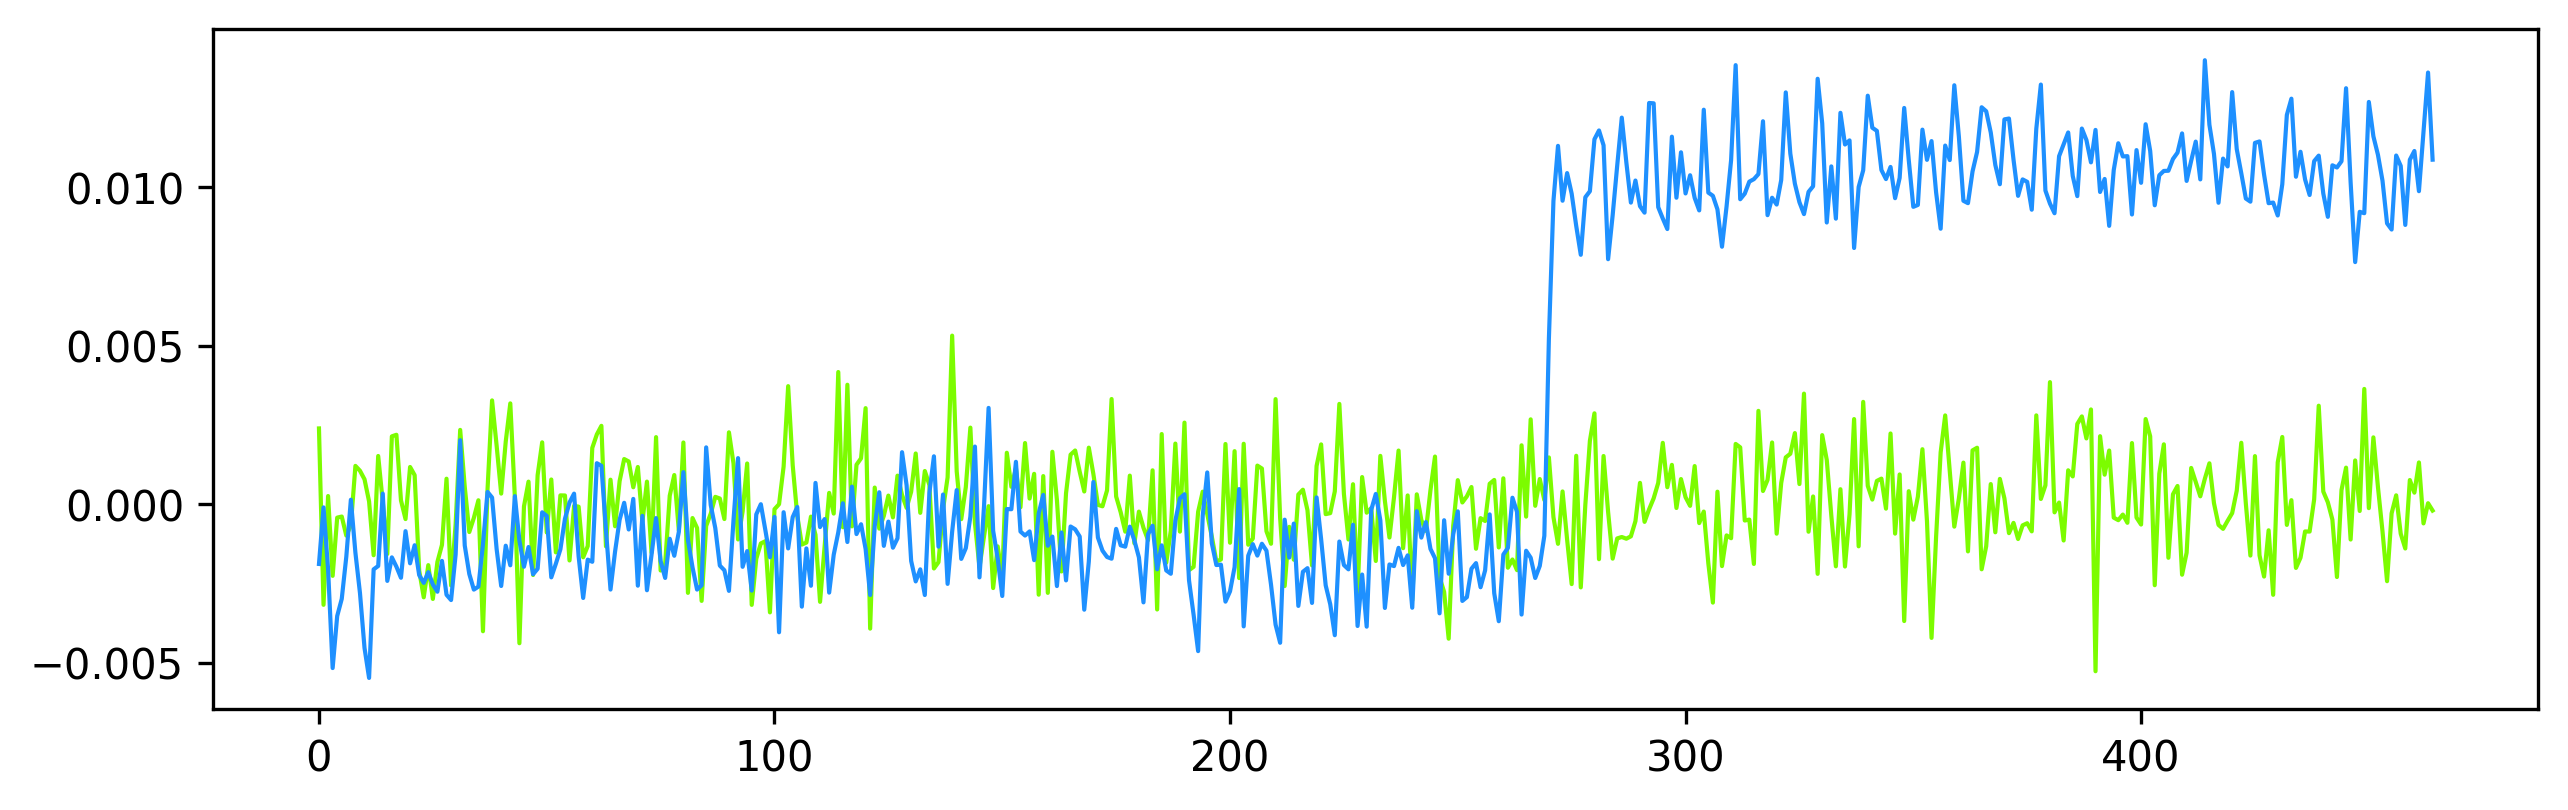

In [60]:
plt.figure()
plt.plot(x_shifts - np.median(x_shifts), color = 'lawngreen', label = '$x$')
plt.plot(y_shifts - np.median(y_shifts), color = 'dodgerblue', label = '$y$')
#plt.ylim(-0.01,0.01)


plt.show()

And finally the white light curve!

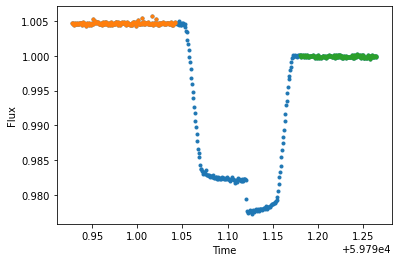

Sdev before tilt (pre transit) =  187.27239050394272  ppm
Sdev after tilt (post transit) =  138.59202297477134  ppm


In [26]:
lc = np.sum(all_spectra, axis=1)/np.sum(all_spectra[-1])

#print(astropy.stats.sigma_clipped_stats(lc[0:165]))

plt.figure()
plt.plot(midtime_bjd[10:], lc[10:], ls='none',marker='.')

plt.plot(midtime_bjd[10:165], lc[10:165], ls='none',marker='.')
plt.plot(midtime_bjd[350:], lc[350:], ls='none',marker='.')


plt.xlabel("Time")
plt.ylabel("Flux")

plt.show()

sdev_lcs = np.std(lc[10:165])
sdev_lce = np.std(lc[350:])

print('Sdev before tilt (pre transit) = ', sdev_lcs*1e6, ' ppm')
print('Sdev after tilt (post transit) = ', sdev_lce*1e6, ' ppm')

We can check the 1/f noise over the whole stack and make a periodogram if we'd like 

(this step takes a while so save it for a rainy day)

In [27]:
#jedi.check_1f(cleaned_data.copy(), fnoise_mask, stack=True)

In [28]:
time_flux = midtime_bjd
wavelength = wvls
flux = all_spectra * integration_time * gain
flux_error = np.sqrt(flux)
quality_flag = np.ones(np.shape(all_spectra), dtype=bool) # for Chromatic
x_shift = x_shifts - np.median(x_shifts)
y_shift = y_shifts - np.median(y_shifts)

output_dict = {
    "bjd_midtimes" : time_flux,
    "wavlength_um" : wavelength,
    "flux" : flux,
    'flux_error' : flux_error,
    'x_shift' : x_shift,
    'y_shift' : y_shift,
    'author' : "Lili Alderson",
    'contact' : "lili.alderson13@gmail.com",
    'code' : "exotic-jedi",
    'notes' : "Using reduction_v7_groupLevelDestriping from Box",
}

pickle.dump(output_dict, open('nrs1_v7_BOXupload.pickle','wb'))

In [30]:
#stellar-spec-W39-G395H-NRS1-exoticjedi-Alderson.xc

import astropy.units as u
from astropy.utils.misc import JsonCustomEncoder
from astropy.time import Time
import xarray as xr

time_flux = midtime_bjd
wavelength = wvls
flux = all_spectra * integration_time * gain
flux_error = np.sqrt(flux)
quality_flag = np.ones(np.shape(all_spectra), dtype=bool) # for Chromatic
x_shift = x_shifts - np.median(x_shifts)
y_shift = y_shifts - np.median(y_shifts)


# put data into a dataset where each
ds = xr.Dataset(
    #now data is a function of two dimensions
    data_vars=dict(flux=(["time_flux","wavelength"], flux,{'units': 'electron'}),
                   flux_error=(["time_flux","wavelength"], flux_error,{'units': 'electron'}),
                   quality_flag=(["time_flux","wavelength"], quality_flag,{'units': ''}),#unitless!
                   x_shift=(["time_flux"], x_shift,{'units': ''}),
                   y_shift=(["time_flux"], y_shift,{'units': ''})
                  ),
    coords=dict(
        wavelength=(["wavelength"], 
                             wavelength,{'units': 'micron'}),#required*
        time_flux=(["time_flux"], 
                             time_flux,{'units': 'bjd'}),#required*
    ),
    attrs=dict(author="L Alderson",#required
               contact="lili.alderson13@gmail.com",#required,
               code="exotic-jedi",#could also insert github link
               notes="Using reduction_v7_groupLevelDestriping from Box",
               normalised="No",
               doi="none",#optional if there is a citation to reference
              )
)


ds.to_netcdf("stellar-spec-W39-G395H-NRS1-exoticjedi-Alderson2.nc")

/tmp/ipykernel_1799195/379332143.py:11: RuntimeWarning: invalid value encountered in sqrt
  flux_error = np.sqrt(flux)
